In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import pprint
import scipy.stats as stats
import urllib
from urllib.parse import quote
import re
from config import yelp_key

In [9]:
#File with 500 largest population ZIP codes in the USA
file = 'input/zipcodes_all.csv'

df_list = pd.read_csv(file)
# Randomly select 100 zipcodes
df_zip = df_list.sample(100)
# df_zip = df_list.iloc[0:100,:]

# When testing use a small set of ZIP Codes: df_zip = df.iloc[0:5,:]
zip_count = df_zip.zip_code.count()
print(f"Total zip codes: {zip_count}")

df_zip.head()

Total zip codes: 100


,zip_code,city,latitude,longetude,population,People / Sq. Mile,National Rank,number,State
167,19102,Philadelphia,39.953423,-75.165384,"4,396","22,186.08",#168,168,Pennsylvania
270,60601,Chicago,41.885805,-87.622911,"5,591","17,101.15",#271,271,Illinois
155,60625,Chicago,41.973081,-87.699751,"91,351","23,681.91",#156,156,Illinois
356,21202,Baltimore,39.296526,-76.607016,"23,572","14,327.41",#357,357,Maryland
148,19139,Philadelphia,39.961529,-75.230259,"43,866","24,062.66",#149,149,Pennsylvania


In [10]:
# Get ready to import yelp data
API_KEY=yelp_key

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
MATCH_PATH = '/v3/businesses/matches'
SEARCH_PHONE_PATH = '/v3/businesses/search/phone'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash

In [11]:
# YELP API call with certain parameters - city, longitude, latitude etc.
def request(host, path, api_key, url_params=None):
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
#     print(u'Querying {0} ...'.format(url))
#     print(headers)

    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json() #, my_url

In [12]:
df_businesses = pd.DataFrame()
df_bus_total = pd.DataFrame()
prices = []
dict_total = {}

for index, row in df_zip.iterrows():
    row_zip = row[0]
    row_city = row[1]
    row_lat = row[2]
    row_long = row[3]
    #     print(index, row_zip, row_lat, row_long)
    url_params={"city":row_city, 'zip_code':row_zip,'latitude':row_lat,'longitude':row_long}
    dict_businesses = request(API_HOST, SEARCH_PATH, API_KEY, url_params)
#     print(dict_businesses)
    try:
        df_businesses['business_id']=[business["id"] for business in dict_businesses['businesses']]
        df_businesses['name']=[business["name"]for business in dict_businesses['businesses']]
        df_businesses['rating']=[business["rating"]for business in dict_businesses['businesses']]
        df_businesses['zip_code']=[business['location']["zip_code"]for business in dict_businesses['businesses']]
        df_businesses['review_count']=[business["review_count"]for business in dict_businesses['businesses']]
        df_businesses['price']=[business["price"]for business in dict_businesses['businesses']]
    except:
        pass
    
    df_bus_total = df_bus_total.append(df_businesses)

df_bus_total.head()

,business_id,name,rating,zip_code,review_count,price
0,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,4.5,19107,5265,$$
1,6ajnOk0GcY9xbb5Ocaw8Gw,Barbuzzo,4.5,19107,2620,$$
2,atZ_olNKXOG4rEr6mccN8g,Beiler's Bakery,4.5,19107,1228,$
3,8pqdJjefYq-a9IBSJJmKwA,The Dandelion,4.0,19103,2270,$$
4,2CDI713ATuxHfnB5b-sBdw,Vedge,4.5,19107,1346,$$$


In [13]:
# CAUTION!
# Specify the file to write to 
output_path = os.path.join("output", "business_data_all.csv")
df_bus_total.to_csv(output_path)

# or use existing .csv file to save on API calls:
# df_bus_total = pd.read_csv('output/business_data_all.csv')

bus_count = df_bus_total['business_id'].count()

print(f"Total Busineses Found: {bus_count}")
# df_bus_total['price'].head()
df_bus_total.head()

Total Busineses Found: 2000


,business_id,name,rating,zip_code,review_count,price
0,ytynqOUb3hjKeJfRj5Tshw,Reading Terminal Market,4.5,19107,5265,$$
1,6ajnOk0GcY9xbb5Ocaw8Gw,Barbuzzo,4.5,19107,2620,$$
2,atZ_olNKXOG4rEr6mccN8g,Beiler's Bakery,4.5,19107,1228,$
3,8pqdJjefYq-a9IBSJJmKwA,The Dandelion,4.0,19103,2270,$$
4,2CDI713ATuxHfnB5b-sBdw,Vedge,4.5,19107,1346,$$$


In [14]:
# Drop duplicates
df_bus_total = df_bus_total.sort_values('business_id')
df_bus_total = df_bus_total.reset_index(drop=True)
df_bus_unique = df_bus_total.drop_duplicates(['business_id'], keep='first')

In [15]:
# CAUTION: Specify the file to write to
output_path = os.path.join("output", "business_unique_data_all.csv")
df_bus_unique.to_csv(output_path)

# Or use saved file for backup
# df_bus_unique = pd.read_csv('output/business_unique_data_all.csv')

# Count unique businesses found
bus_uni_count = df_bus_unique.business_id.count()
print(f"Total unique businesses: {bus_uni_count}")


df_bus_unique.head()

Total unique businesses: 1684


,business_id,name,rating,zip_code,review_count,price
0,-5gWvrcKOPmhlcZju3tpbw,Flour Bakery + Café,4.5,02210,1139,$$
2,-6K4x5d3IfeF1LMcOXmJIw,Revel Restaurant & Bar,4.0,11530,507,$$$
3,-6tSx9IXwt1btreBtcyZ0g,Würstbar,4.5,07302,293,$$
4,-8HsKILlFcC8ieznte56eg,Lulu's Bakery,4.0,11366,346,$$
5,-DrR38H1Abk0wCyu9XOLug,Sweet Maple,4.0,94115,3588,$$


In [16]:
# Get reviews for each unique business
dict_rev_total = {}
dict_reviews = {}
df_reviews = pd.DataFrame()
df_rev_total = pd.DataFrame()

for index, row in df_bus_unique.iterrows():
    row_bus = row[0]
    # CAUTION row[1] when reading from .csv!!!
#     print(row_bus)
    REVIEW_PATH = BUSINESS_PATH + row_bus + '/reviews'
    dict_reviews = request(API_HOST, REVIEW_PATH, API_KEY)
#     pprint.pprint(dict_reviews)
    try:
        df_reviews['business_id']= [row_bus for review in dict_reviews['reviews']]
        df_reviews['review_id']=[review["id"]for review in dict_reviews['reviews']]
        df_reviews['rating']=[review["rating"]for review in dict_reviews['reviews']]
        df_reviews['name']=[review['user']["name"]for review in dict_reviews['reviews']]
        df_rev_total = df_rev_total.append(df_reviews)
    except:
        pass

In [17]:
df_rev_total.head()

,business_id,review_id,rating,name
0,-5gWvrcKOPmhlcZju3tpbw,BO3q4-Qhx5XqJ9zZyqVJaw,5,Sherry S.
1,-5gWvrcKOPmhlcZju3tpbw,XCqK4aeXmMQIZ9OqV6damQ,2,Nancy H.
2,-5gWvrcKOPmhlcZju3tpbw,oRP2go0MEQjMf8h8ayjfZQ,5,Katrina K.
0,-6K4x5d3IfeF1LMcOXmJIw,wTmQSRU7QskZYy1QhxGZew,5,Dan R.
1,-6K4x5d3IfeF1LMcOXmJIw,4T31vTSqxu0M0OEF5V6oqg,3,Alex B.


In [18]:
# CAUTION: Specify the file to write to
output_path = os.path.join("output", "review_data_all.csv")
df_rev_total.to_csv(output_path)

# Or use saved file for backup
# df_rev_total = pd.read_csv('output/review_data_all.csv')

# Count unique businesses found
rev_count = df_rev_total['review_id'].count()
print(f"Total reviews: {rev_count}")

Total reviews: 5040


In [19]:
#COMMENT OUT THE RESET BELOW IF RAN MULTIPLE TIMES!!!!

df_rev_total.reset_index(inplace=True)

# create a list with names per review and take only the name before the 'space' as a first name
df_rev_total['short name']=""
short_name = []
for index, row in df_rev_total.iterrows():
#     print(row)
    short_name = re.split("( )",row[4])
    df_rev_total.iloc[index, 5] = short_name[0].lower()

In [20]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")

# CAUTION: Specify the file to write to
output_path = os.path.join("output", "review_data_all.csv")
df_rev_total.to_csv(output_path)

df_rev_total.head()

Total reviews: 5040


,index,business_id,review_id,rating,name,short name
0,0,-5gWvrcKOPmhlcZju3tpbw,BO3q4-Qhx5XqJ9zZyqVJaw,5,Sherry S.,sherry
1,1,-5gWvrcKOPmhlcZju3tpbw,XCqK4aeXmMQIZ9OqV6damQ,2,Nancy H.,nancy
2,2,-5gWvrcKOPmhlcZju3tpbw,oRP2go0MEQjMf8h8ayjfZQ,5,Katrina K.,katrina
3,0,-6K4x5d3IfeF1LMcOXmJIw,wTmQSRU7QskZYy1QhxGZew,5,Dan R.,dan
4,1,-6K4x5d3IfeF1LMcOXmJIw,4T31vTSqxu0M0OEF5V6oqg,3,Alex B.,alex


In [21]:
# Read all names from gender file into new dataframe
file = 'input/gender names.csv'
df = pd.read_csv(file)
df = df.set_index('first_name')
df.head()

,nameprimary,gender,count
first_name,,,
aa,AA,Not Known,1
aabha,AABHA,Female,1
aabida,AABIDA,Female,1
aad,AAD,Male,1
aadarsh,AADARSH,Male,1


In [22]:
# Loop through reviews and find gender for each reviewer 
df_rev_total['gender']=""
gender = []
for index, row in df_rev_total.iterrows():
    try:
        gender = df.loc[str(row[5]),'gender']
        df_rev_total.iloc[index, 6] = gender
    except:
        pass

# Drop reviews with where gender isn't found
df_rev_total = df_rev_total.loc[(df_rev_total['gender']!="") 
                                & (df_rev_total['gender']!="Both") 
                                & (df_rev_total['gender']!="Not Known")]

In [23]:
df_rev_total.head()

,index,business_id,review_id,rating,name,short name,gender
0,0,-5gWvrcKOPmhlcZju3tpbw,BO3q4-Qhx5XqJ9zZyqVJaw,5,Sherry S.,sherry,Female
1,1,-5gWvrcKOPmhlcZju3tpbw,XCqK4aeXmMQIZ9OqV6damQ,2,Nancy H.,nancy,Female
2,2,-5gWvrcKOPmhlcZju3tpbw,oRP2go0MEQjMf8h8ayjfZQ,5,Katrina K.,katrina,Female
3,0,-6K4x5d3IfeF1LMcOXmJIw,wTmQSRU7QskZYy1QhxGZew,5,Dan R.,dan,Male
5,2,-6K4x5d3IfeF1LMcOXmJIw,QAJwODgMzSUOtU-5Kh4F_Q,3,Linda K.,linda,Female


In [49]:
# Rename duplicate column names 'rating' and 'name'
df_rev_total = df_rev_total.rename(columns={'rating':'reviewer_rating', 'name':'reviewer_full'})
rev_gender_count = df_rev_total.review_id.count()
print(f"Total reviews with gender: {rev_gender_count}")

# Specify the file to write to
output_path = os.path.join("output", "review_data_all.csv")
df_rev_total.to_csv(output_path)

df_rev_total.head()

Total reviews with gender: 4055


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender
0,0,-5gWvrcKOPmhlcZju3tpbw,BO3q4-Qhx5XqJ9zZyqVJaw,5,Sherry S.,sherry,Female
1,1,-5gWvrcKOPmhlcZju3tpbw,XCqK4aeXmMQIZ9OqV6damQ,2,Nancy H.,nancy,Female
2,2,-5gWvrcKOPmhlcZju3tpbw,oRP2go0MEQjMf8h8ayjfZQ,5,Katrina K.,katrina,Female
3,0,-6K4x5d3IfeF1LMcOXmJIw,wTmQSRU7QskZYy1QhxGZew,5,Dan R.,dan,Male
5,2,-6K4x5d3IfeF1LMcOXmJIw,QAJwODgMzSUOtU-5Kh4F_Q,3,Linda K.,linda,Female


In [50]:
# Reuse file if needed
# df_rev_total = pd.read_csv('output/review_data_all.csv')
# df_bus_unique = pd.read_csv('output/business_unique_data_all.csv')
# Merge reviews with gender and businesses
df_total = pd.merge(df_rev_total, df_bus_unique,on=('business_id'))
df_total.review_id.count()

4055

In [51]:
# Save a version of the final data used in the presentation in case you need to rerun it
# df_total = pd.read_csv('output/total_everything_all.csv')
df_total = df_total.drop_duplicates(['review_id'])
# df_total.head()

total_count = df_total.review_id.count()
print(f"Total reviews: {total_count}")

Total reviews: 4055


In [52]:
# Add a column to store price as a number for statical calculations
df_total['price_num'] = df_total['price']
df_total['price_num'] = df_total['price_num'].replace(
    {'$':1,'$$':2,'$$$':3,'$$$$':4})

# Overwrite total_everything file
output_path = os.path.join("output", "total_everything_all.csv")
df_total.to_csv(output_path)

df_total['price'].value_counts()

$$      2569
$       1129
$$$      267
$$$$      90
Name: price, dtype: int64

Female    2476
Male      1579
Name: gender, dtype: int64


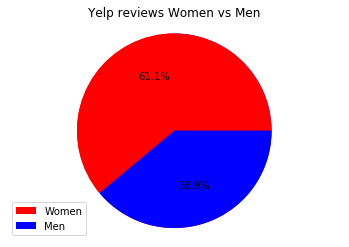

In [53]:
total_reviews = df_total['gender'].value_counts()

plt.clf()
colors = ['red', 'blue']
labels = ['Women','Men']
patches, texts = plt.pie(total_reviews, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(total_reviews, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews Women vs Men")
plt.savefig("Images/Women_vw_Men_all.png")

print(total_reviews)


price
$       459
$$      979
$$$     106
$$$$     35
Name: price, dtype: int64

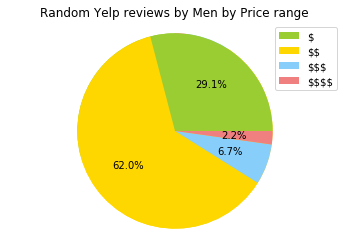

In [54]:
# use line below to bypass API calls
# df_total = pd.read_csv('output/total_everything_all.csv')

men_sizes = []
df_only_men = df_total.loc[(df_total["gender"] == 'Male')]

df_only_men_price_count = df_only_men.loc[(df_only_men["price"] != '*')]
df_only_men_price_count = df_only_men.dropna(how='any')

df_only_men_price_count_gb = df_only_men_price_count.groupby(['price'])
# df_only_men_price_count_gb = df_only_men_price_count.groupby(['reviewer_rating'])

men_sizes = df_only_men_price_count_gb['price'].count()
# men_sizes = df_only_men_price_count_gb['reviewer_rating'].count()

# avg_rating_men = df_only_men_price_count['reviewer_rating'].mean()
# print(avg_rating_men)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']

patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(men_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Random Yelp reviews by Men by Price range")
plt.savefig("Images/Men_Price_Reviews_all.png")
# df_only_men_price_count['reviewer_rating'].value_counts()
men_sizes
# df_total.head(50)

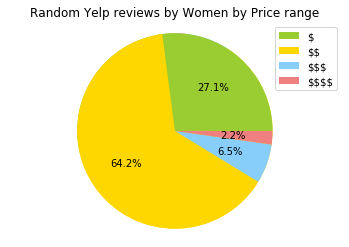

price
$        670
$$      1590
$$$      161
$$$$      55
Name: price, dtype: int64

In [55]:
women_sizes = []
df_only_women = df_total.loc[(df_total["gender"] == 'Female')]

df_only_women_price_count = df_only_women.loc[(df_only_women["price"] != '*')]
df_only_women_price_count = df_only_women.dropna(how='any')

df_only_women_price_count_gb = df_only_women_price_count.groupby(['price'])
# df_only_women_price_count_gb = df_only_women_price_count.groupby(['reviewer_rating'])

women_sizes = df_only_women_price_count_gb['price'].count()
# women_sizes = df_only_women_price_count_gb['reviewer_rating'].count()

# avg_rating_women = df_only_women_price_count['rating'].mean()
# print(avg_rating_women)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']
patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(women_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Random Yelp reviews by Women by Price range")
plt.savefig("Images/Women_Price_Reviews_all.png")
plt.show()
women_sizes

In [56]:
df_total_male.head()

,index,business_id,review_id,rating_x,name_x,short name,gender,name_y,rating_y,zip_code,review_count,price,price_num
3,0,-6K4x5d3IfeF1LMcOXmJIw,wTmQSRU7QskZYy1QhxGZew,5,Dan R.,dan,Male,Revel Restaurant & Bar,4.0,11530,507,$$$,3
6,1,-6tSx9IXwt1btreBtcyZ0g,9Rc54mUS2r2Bt2so1YhdZg,2,David P.,david,Male,Würstbar,4.5,07302,293,$$,2
9,1,-8HsKILlFcC8ieznte56eg,wNWHeIHL5pCMaAk42kiZNA,5,Mickel E.,mickel,Male,Lulu's Bakery,4.0,11366,346,$$,2
16,2,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.,julian,Male,Serious Pie,4.0,98121,4083,$$,2
17,0,-LJayGlySYnQ8z2VvZyFNw,Pb3kmwLy9_vOZSRvV0rMZg,5,Kevin G.,kevin,Male,Little Vietnam,4.5,60640,328,$,1


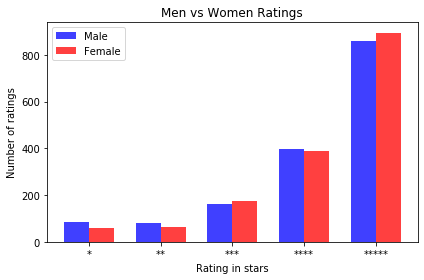

In [57]:
df_total_male = df_total.loc[df_total['gender']=='Male']
df_total_female = df_total.loc[df_total['gender']=='Female']

max_men = df_total_male['reviewer_rating'].count()
df_total_female = df_total_female.iloc[0:max_men,:]

df_total_m_f = df_total_male
df_total_m_f = df_total_m_f.append(df_total_female)

df_summary_reviews_gb = df_total_m_f.groupby(['reviewer_rating','gender'])
df_summary_reviews = pd.DataFrame(df_summary_reviews_gb['review_id'].count())
df_summary_pivot = df_summary_reviews.pivot_table('review_id','reviewer_rating','gender')
df_summary_pivot
n_groups = 5

female = df_summary_pivot['Female'].astype(int)
male = df_summary_pivot['Male'].astype(int)

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.75

rects1 = plt.bar(index, male, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Male')

rects2 = plt.bar(index + bar_width, female, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Female')

plt.xlabel("Rating in stars")
plt.ylabel("Number of ratings")
plt.savefig("Images/Men_vs_Women_Rating.png")
plt.title("Men vs Women Ratings")
plt.xticks(index + bar_width / 2, ('*', '**', '***', '****', '*****'))
plt.legend()

plt.tight_layout()
plt.show()

In [59]:
df_total.head()

female_price = df_total.loc[(df_total["gender"]=='Female') , ["price_num"]]
male_price = df_total.loc[(df_total["gender"]=='Male'), ["price_num"]]
# female_price = df_total.loc[(df_total["gender"]=='Female') & (df_total["reviewer_rating"] == 5) , ["price_num"]]
# male_price = df_total.loc[(df_total["gender"]=='Male') & (df_total["reviewer_rating"] == 5), ["price_num"]]

female_price = female_price.fillna(0)
male_price = male_price.fillna(0)

stats.ttest_ind(female_price, male_price, equal_var=False)
# female_price.count()

Ttest_indResult(statistic=array([0.87847377]), pvalue=array([0.37975038]))

In [60]:
female_rating = df_total.loc[df_total["gender"]=='Female', ["reviewer_rating"]]
male_rating = df_total.loc[df_total["gender"]=='Male', ["reviewer_rating"]]

fem_avg = female_rating.mean()
print(f"Female Rating Average {fem_avg}")
male_avg = male_rating.mean()
print(f"Male Rating Average {male_avg}")

stats.ttest_ind(female_rating, male_rating, equal_var=False)

Female Rating Average reviewer_rating    4.252423
dtype: float64
Male Rating Average reviewer_rating    4.176061
dtype: float64


Ttest_indResult(statistic=array([2.14421621]), pvalue=array([0.03209211]))